In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import catboost

In [35]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

In [95]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
subm = pd.read_csv('./sample_submission.csv')

In [96]:
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [97]:
train_A = train[train['PRODUCT_CODE']=='A_31'].reset_index(drop=True)
train_T = train[train['PRODUCT_CODE']=='T_31'].reset_index(drop=True)
train_O = train[train['PRODUCT_CODE']=='O_31'].reset_index(drop=True)

test_A = test[test['PRODUCT_CODE']=='A_31']
test_T = test[test['PRODUCT_CODE']=='T_31']
test_O = test[test['PRODUCT_CODE']=='O_31']

In [98]:
print(len(train_A))
print(len(train_T))
print(len(train_O))
print()
print(len(test_A))
print(len(test_T))
print(len(test_O))

249
343
6

67
239
4


In [99]:
# 열에서 모든 값이 nan이면 train, test에서 열 제거
def remove_col(train_df, test_df):
    for x in train_df.columns[6:]:
        if train_df[x].nunique() == 0 or list(train_df[x].unique()) == [0]:
            train_df.drop(columns=[x], inplace=True)
            test_df.drop(columns=[x], inplace=True)
        elif train_df[x].nunique() == 1 and test_df[x].nunique() == 1 and train_df[x].unique()[0] == 0 and test_df[x].unique()[0] == 0:
            train_df.drop(columns=[x], inplace=True)
            test_df.drop(columns=[x], inplace=True)
    return train_df, test_df

In [100]:
train_A, test_A = remove_col(train_A, test_A)
train_T, test_T = remove_col(train_T, test_T)
train_O, test_O = remove_col(train_O, test_O)

In [102]:
len(train_A)

249

In [103]:
sorted(train_A.isnull().sum())

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [67]:
train_A.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Quality'], inplace=True)
train_T.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Quality'], inplace=True)
train_O.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Quality'], inplace=True)

test_A = test_A[train_A.columns[1:]]
test_T = test_T[train_T.columns[1:]]
test_O = test_O[train_O.columns[1:]]

In [68]:
train_x_A, train_y_A = train_A.drop(columns=['Y_Class']), train_A['Y_Class']
train_x_T, train_y_T = train_T.drop(columns=['Y_Class']), train_T['Y_Class']
train_x_O, train_y_O = train_O.drop(columns=['Y_Class']), train_O['Y_Class']

In [69]:
train_x_A.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,X_10,...,X_924,X_925,X_926,X_927,X_928,X_929,X_930,X_931,X_932,X_933
0,4,2,2.0,102.0,45.0,11.0,45.0,10.0,31.0,2.0,...,172.5,162.8,157.235484,150.9,326.0,309.290909,290.0,13.7,13.443333,13.2
1,4,2,2.0,102.0,45.0,11.0,45.0,10.0,31.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,2,2.0,97.0,45.0,11.0,45.0,10.0,31.0,2.0,...,177.8,157.1,154.074194,150.9,327.0,310.854546,298.0,13.7,13.454839,13.2
3,5,2,2.0,95.0,45.0,10.0,54.0,10.0,52.0,2.0,...,166.9,158.5,151.096774,146.5,327.0,313.618182,299.0,13.7,13.461290,13.3
4,4,2,2.0,100.0,45.0,11.0,45.0,10.0,31.0,2.0,...,177.9,161.3,156.038710,149.1,327.0,312.109091,298.0,13.7,13.422581,13.2


In [70]:
# stscaler = StandardScaler().fit(train_x_A)
# train_x_A = pd.DataFrame(stscaler.transform(train_x_A), columns=train_x_A.columns)
# test_A = pd.DataFrame(stscaler.transform(test_A), columns=test_A.columns)
# test_A.head()

# stscaler = StandardScaler().fit(train_x_T)
# train_x_T = pd.DataFrame(stscaler.transform(train_x_T), columns=train_x_T.columns)
# test_T = pd.DataFrame(stscaler.transform(test_T), columns=test_T.columns)
# test_T.head()

# stscaler = StandardScaler().fit(train_x_O)
# train_x_O = pd.DataFrame(stscaler.transform(train_x_O), columns=train_x_O.columns)
# test_O = pd.DataFrame(stscaler.transform(test_O), columns=test_O.columns)
# test_O.head()

In [71]:
train_x_A.fillna(0, inplace=True)
train_x_T.fillna(0, inplace=True)
train_x_O.fillna(0, inplace=True)

test_A.fillna(0, inplace=True)
test_T.fillna(0, inplace=True)
test_O.fillna(0, inplace=True)

In [72]:
# 상관계수 == 1 이면 제거
def same_corr_drop(train_df):
    tmp = train_df[train_df.columns[2:]].corr()
    for e, c in enumerate(tmp.columns):
        for i in range(e+1, len(tmp.columns)):
            if abs(tmp[c][i]) == 1 and tmp.columns[i] in train_df.columns:
                train_df.drop(columns=[tmp.columns[i]], inplace=True)
    return train_df

train_x_A = same_corr_drop(train_x_A)
train_x_T = same_corr_drop(train_x_T)
train_x_O = same_corr_drop(train_x_O)

test_A = test_A[train_x_A.columns]
test_T = test_T[train_x_T.columns]
test_O = test_O[train_x_O.columns]

In [73]:
train_x_A.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,X_10,...,X_903,X_904,X_905,X_906,X_907,X_908,X_909,X_931,X_932,X_933
0,4,2,2.0,102.0,45.0,11.0,45.0,10.0,31.0,2.0,...,9.000000,9.0,0.0,17.28,17.277333,17.27,0.01,13.7,13.443333,13.2
1,4,2,2.0,102.0,45.0,11.0,45.0,10.0,31.0,2.0,...,0.000000,0.0,0.0,0.00,0.000000,0.00,0.00,0.0,0.000000,0.0
2,4,2,2.0,97.0,45.0,11.0,45.0,10.0,31.0,2.0,...,8.516129,8.0,1.0,17.28,17.276452,17.27,0.01,13.7,13.454839,13.2
3,5,2,2.0,95.0,45.0,10.0,54.0,10.0,52.0,2.0,...,8.387097,8.0,1.0,17.28,17.276452,17.27,0.01,13.7,13.461290,13.3
4,4,2,2.0,100.0,45.0,11.0,45.0,10.0,31.0,2.0,...,8.903226,8.0,1.0,17.28,17.277419,17.27,0.01,13.7,13.422581,13.2


In [74]:
### LDA, PCA / permutation selection, stepwise selection, embedded selection 등을 활용해서 feature를 우선 줄여야 함.

,pc_ratio
pc1,6.822555e-01
pc2,3.177445e-01
pc3,4.325159e-14
pc4,2.810452e-15
pc5,9.839323e-16


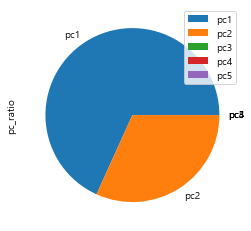

In [28]:
pca = PCA()
pca.fit(train_x_A)
ratio = pca.explained_variance_ratio_

df_v = pd.DataFrame(ratio[:5], index=[f'pc{i+1}' for i in range(5)], columns=['pc_ratio'])
df_v.plot.pie(y='pc_ratio')
df_v

In [29]:
n = 2
pca = PCA(n_components=n)
train_x_A = pd.DataFrame(pca.fit_transform(train_x_A), columns = [f'pc{i+1}' for i in range(n)])
test_A = pd.DataFrame(pca.transform(test_A), columns = [f'pc{i+1}' for i in range(n)])
train_x_A.head()

,pc1,pc2
0,1.388780e+13,3.343441e+12
1,-1.333239e+13,1.201185e+13
2,1.388780e+13,3.343441e+12
3,-1.333239e+13,1.201185e+13
4,1.388780e+13,3.343441e+12


,pc_ratio
pc1,0.793408
pc2,0.150063
pc3,0.048538
pc4,0.007514
pc5,0.000305


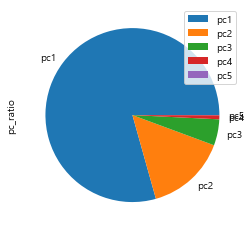

In [30]:
pca = PCA()
pca.fit(train_x_T)
ratio = pca.explained_variance_ratio_

df_v = pd.DataFrame(ratio[:5], index=[f'pc{i+1}' for i in range(5)], columns=['pc_ratio'])
df_v.plot.pie(y='pc_ratio')
df_v

In [31]:
n = 3
pca = PCA(n_components=n)
train_x_T = pd.DataFrame(pca.fit_transform(train_x_T), columns = [f'pc{i+1}' for i in range(n)])
test_T = pd.DataFrame(pca.transform(test_T), columns = [f'pc{i+1}' for i in range(n)])
train_x_T.head()

,pc1,pc2,pc3
0,19688.075742,386.215166,-11596.255440
1,19702.925232,422.012139,-11598.160334
2,21340.723518,1658.835950,-12274.216641
3,-17213.386432,-16426.705059,-11909.157370
4,21585.569022,1847.298186,-12373.268486


,pc_ratio
pc1,9.603176e-01
pc2,3.874050e-02
pc3,9.378484e-04
pc4,3.235487e-06
pc5,7.803856e-07


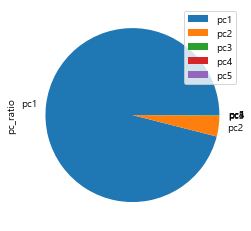

In [32]:
pca = PCA()
pca.fit(train_x_O)
ratio = pca.explained_variance_ratio_

df_v = pd.DataFrame(ratio[:5], index=[f'pc{i+1}' for i in range(5)], columns=['pc_ratio'])
df_v.plot.pie(y='pc_ratio')
df_v

In [33]:
n = 2
pca = PCA(n_components=n)
train_x_O = pd.DataFrame(pca.fit_transform(train_x_O), columns = [f'pc{i+1}' for i in range(n)])
test_O = pd.DataFrame(pca.transform(test_O), columns = [f'pc{i+1}' for i in range(n)])
train_x_O.head()

,pc1,pc2
0,19135.025366,-4117.523175
1,-19976.056048,111.749584
2,19162.910616,-4130.671475
3,-19970.631174,112.807594
4,21223.848405,7830.918964


In [75]:
def Borderline_SMOTE_Class(train_x_df, train_y_df):
    B_SMOTE = BorderlineSMOTE()
    x_b_smote, y_b_smote = B_SMOTE.fit_resample(train_x_df, train_y_df)
    return x_b_smote, y_b_smote

In [51]:
# train_x_A, train_y_A = Borderline_SMOTE_Class(train_x_A, train_y_A)
# train_x_T, train_y_T = Borderline_SMOTE_Class(train_x_T, train_y_T)

In [83]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

for train_x, train_y in tqdm(zip([train_x_A, train_x_T], [train_y_A, train_y_T])):
    f1_list = []
    for fold, (train_index, val_index) in enumerate(rskfold.split(train_x, train_y)):
        x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
        x_trn, y_trn = Borderline_SMOTE_Class(x_trn, y_trn)
        
        #clf = RandomForestClassifier(verbose=0, n_jobs=4).fit(x_trn, y_trn)
        clf = catboost.CatBoostClassifier(learning_rate=0.05, iterations=500, verbose=0, task_type="GPU") # cpu -> thread_count=5
        clf.fit(x_trn, y_trn, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])
        f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))

    print(f1_list, np.mean(f1_list))

1it [01:23, 83.08s/it]

[0.39631336405529954, 0.304, 0.39923809523809517, 0.304, 0.4175627240143369, 0.39923809523809517, 0.2986666666666667, 0.39923809523809517, 0.304, 0.47560975609756095, 0.30158730158730157, 0.37462052216150576, 0.39923809523809517, 0.3987611304684475, 0.40168970814132104] 0.37158423694298803


2it [03:51, 115.78s/it]

[0.7613485280151947, 0.6650440917107585, 0.694602924781953, 0.7286324786324787, 0.6296296296296297, 0.5698590739142939, 0.5518617614269788, 0.7178362573099415, 0.7941601255886969, 0.6908496732026145, 0.6973180076628352, 0.8127490957679636, 0.7326007326007327, 0.5658579816107234, 0.7119039825422804] 0.6882836229598049


In [79]:
(343*0.3915 + 249*0.6673) / (343+249)

0.5075037162162163

In [166]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

for train_x, train_y in tqdm(zip([train_x_A, train_x_T], [train_y_A, train_y_T])):

    f1_list = []
    for fold, (train_index, val_index) in enumerate(rskfold.split(train_x, train_y)):
        x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
        clf = RandomForestClassifier(verbose=0, n_jobs=4).fit(x_trn, y_trn)
        #clf = catboost.CatBoostClassifier(verbose=0, thread_count=4).fit(x_trn, y_trn)
        f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))

    print(f1_list, np.mean(f1_list))

1it [00:01,  1.47s/it]

[0.6665536723163842, 0.7641325536062378, 0.6377184720041863, 0.7091358024691359, 0.485546711353163, 0.4867545735329057, 0.5873517786561265, 0.6891817249270101, 0.6924288233812043, 0.6676094276094277] 0.6386413539855782


2it [00:02,  1.43s/it]

[0.48209446380178084, 0.30158730158730157, 0.39923809523809517, 0.4175627240143369, 0.304, 0.39923809523809517, 0.30158730158730157, 0.30158730158730157, 0.304, 0.5677992041628406] 0.3778694487217053


In [72]:
for train_x, train_y, test_x in zip([train_x_A, train_x_T], [train_y_A, train_y_T], [test_x_A, test_x_T]):
    train_x, train_y = Borderline_SMOTE_Class(train_x, train_y)
    clf = catboost.CatBoostClassifier(verbose=0).fit(train_x, train_y)
    pred = clf.predict(test_x)
    
    for i, idx in enumerate(test_x.index):
        subm['Y_Class'][idx] = pred[i]

        
        
clf = catboost.CatBoostClassifier(verbose=0, thread_count=5).fit(train_x_O, train_y_O)
pred = clf.predict(test_x_O)

for i, idx in enumerate(test_x_O.index):
    subm['Y_Class'][idx] = pred[i]

In [ ]:
# rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# for train_x_df, train_y_df in tqdm(zip([train_xx], [train_yy])):
#     train_x_df, train_y_df = Borderline_SMOTE_Class(train_x_df, train_y_df)
    
#     f1_list = []
#     for fold, (train_index, val_index) in enumerate(rskfold.split(train_x_df, train_y_df)):
#         x_trn, x_val, y_trn, y_val = train_x_df.loc[train_index], train_x_df.loc[val_index], train_y_df.loc[train_index], train_y_df.loc[val_index]
#         clf = RandomForestClassifier(verbose=0, n_jobs=4).fit(x_trn, y_trn)
#         #clf = catboost.CatBoostClassifier(verbose=0, thread_count=4).fit(x_trn, y_trn)
#         f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
        
#     print(f1_list, np.mean(f1_list))

In [73]:
subm.Y_Class.value_counts()

1    276
0     32
2      2
Name: Y_Class, dtype: int64

In [27]:
subm.to_csv('./submission_30.csv', index=False)

In [ ]:
# catboost에서 tuning?